In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import json
import matplotlib.patches as patches
from mpl_toolkits import mplot3d
from matplotlib import colors
import os
import pickle


In [2]:
# Data packet structure
# Every file contains a list of packets. Each packet is of size 1206.
# Each packet contains 12 datablocks.
# Each datablock contains 32 channels.
packet_size = 1206
num_datablocks = 12
num_channels = 32
datablock_size = 100
azimuth_size = 2
channel_size = 3 
flag_size = 2
rpm = 600
firing_cycle_us = 55.296

def get_spacing(values):
    spacing = []
    for i in range(len(values)):
        diff = values[(i+1) % len(values)] - values[i]
        if abs(diff) > 35900:
            diff = diff + 35900

        # Don't include outlier data points
        if abs(diff) < 40:
            spacing.append(diff/100.0)    

    return spacing

# Little Endian bytes
def pack_2_bytes(bytes : list):
    return bytes[1] << 8 | bytes[0]

def get_elevation_index(input_angle):
    # print("elevation angle [deg]:", input_angle)
    # print("row idx", int(laser_table['ROW_IDX'][np.abs(np.array(laser_table['ELEVATION_ANGLE']) - input_angle).argmin()]))
    return int(laser_table['ROW_IDX'][np.abs(np.array(laser_table['ELEVATION_ANGLE']) - input_angle).argmin()])


def get_azimuth_resolution(rpm, firing_cycle_us) -> float:
    return rpm * 360 / 60.0 * firing_cycle_us * 10**(-6)

def get_azimuth_count(az_resolution) -> int:
    return int(np.round(360.0 / az_resolution))

def get_azimuth_index(input_angle):
    azimuth = (input_angle + 360 ) % 360 # Convert to positive angles
    return int(np.floor(azimuth / updated_azimuth_resolution))

azimuth_resolution = get_azimuth_resolution(rpm, firing_cycle_us)
azimuth_count = get_azimuth_count(azimuth_resolution)
updated_azimuth_resolution = 360.0 / azimuth_count

In [3]:
### Config ###
date = '2019_02_27'
seq = '0009'
frame_id = 0


In [4]:
BASE = "C:/Users/meiqt/Repos/dataset/cadcd"
filename = "packets_"+ str(frame_id) + ".pkl"
lidar_path = os.path.join(BASE, date + '/' + seq + "/packets/" + filename)
laser_table = np.genfromtxt('laser_table.csv', dtype=float, delimiter=',', names=True) 
file = open(lidar_path, 'rb')

In [6]:
# Cropping
x_range = [-50, 50] 
y_range = [-50, 50]

snow_cropping_x_range = x_range
snow_cropping_y_range = [-10, 16]

In [7]:
lidar_data = pickle.load(file, encoding="bytes")[151 * frame_id:]

frame_raw_data = np.ndarray((len(lidar_data), packet_size))  # (151, 1206)

for i, packet in enumerate(lidar_data):
    byte_array_list = list(bytearray(packet))

    if len(byte_array_list) != packet_size:
        raise Exception("Packet Size not as expected")

    frame_raw_data[i] = byte_array_list
    
print("frame_raw_data.shape:", frame_raw_data.shape)

frame_raw_data.shape: (151, 1206)


In [82]:
# Init 
datablocks = np.ndarray((num_datablocks * frame_raw_data.shape[0], datablock_size), dtype='uint16') # Number of packets in frame x 12
azimuth_values = []
frame_parsed_data = []

# Get list of datablocks
for ipacket, packet in enumerate(frame_raw_data):
    for idatablock in range(num_datablocks):
        datablocks[ipacket * num_datablocks + idatablock] = packet[idatablock * datablock_size : idatablock * datablock_size + datablock_size]

# Get Azimuth and Channel data for each datablock
for idatablock, datablock in enumerate(datablocks):
    next_datablock = datablocks[(idatablock + 1) % len(datablocks)]
    idx = 0
    idx += flag_size

    azimuth = pack_2_bytes(datablock[idx:idx + azimuth_size]) / 100.0
    next_azimuth = pack_2_bytes(next_datablock[idx:idx + azimuth_size]) / 100.0
    azimuth_gap = next_azimuth - azimuth

    if azimuth > 35999:
        print("Azimuth out of range", azimuth)
        print(datablock)
        raise Exception("Azimuth out of range")

    azimuth_values.append(azimuth)
    idx += azimuth_size

    # Channels
    channels = np.ndarray((32, 4))
    for ichannel in range(num_channels):
        channel_data = datablock[idx:idx + channel_size]

        # elevation row index (index of the elevation row in range image) [0-31]
        irow = laser_table['ROW_IDX'].astype(int)[ichannel]
        elevation = laser_table['ELEVATION_ANGLE'][ichannel] # [deg]
   
        # Corrected azimuth wrt current azimuth gap
        azimuth_corrected = azimuth + laser_table['AZIMUTH_OFFSET'][ichannel] \
            + azimuth_gap * (laser_table['TIMING_OFFSET_US'][ichannel] / 55.296) # [deg]
        # print("azimuth_corrected", azimuth_corrected)

        # Distance
#         print("channel_data['0']", channel_data[0])
#         print("channel_data['1']", channel_data[1])
#         print("channel_data['2']", channel_data[2])
#         print("pack2bytes", float(pack_2_bytes(channel_data[:2]))*4/100.0)
        
        distance = float(channel_data[1] * 2**8 + channel_data[0]) * 4 / 1000.0
        
#         print("distance", distance)

#         distance = float(str(channel_data[1] * 4) + '.' + str(channel_data[0] * 4))

        # Reflectivity
        reflectivity = channel_data[2]
        if (reflectivity > 255 or reflectivity < 0):
            raise Exception

        channels[irow] = [elevation, azimuth_corrected, distance, reflectivity]
        idx += channel_size
        
    frame_parsed_data.append(channels)
    
frame_parsed_data = np.asarray(frame_parsed_data)
frame_parsed_data = np.transpose(frame_parsed_data, (1, 0, 2)) # transpose height and width, without changing depth
print("frame_parsed_data.shape:", frame_parsed_data.shape) # (32, 1812, 3)

h, w, d = frame_parsed_data.shape
print("h, w, d:", h, w, d)

range_image_elevations = frame_parsed_data[:, :, 0]
range_image_azimuths = frame_parsed_data[:, :, 1]
range_image_distance = frame_parsed_data[:, :, 2]
range_image_reflectivity = frame_parsed_data[:, :, 3]

frame_parsed_data.shape: (32, 1812, 4)
h, w, d: 32 1812 4


In [83]:
# parse table to create point cloud 
def build_point_cloud(frame_parsed_data):
    point_cloud = []
    for i in range(h):
        for j in range(w):
            elevation, azimuth_corrected, distance, reflectivity = frame_parsed_data[i, j]

            azimuth_corrected_rad = np.radians(azimuth_corrected)
            elevation_rad = np.radians(elevation)

            point_x = distance * np.cos(elevation_rad) * np.sin(azimuth_corrected_rad)
            point_y = distance * np.cos(elevation_rad) * np.cos(azimuth_corrected_rad)
            point_z = distance * np.sin(elevation_rad)

            if distance > 0.0:
                point_cloud.append([point_y, -point_x, point_z, reflectivity]) # x_coord = y, y_coord=-x, z = z (convert to ROS coord system)

    return np.asarray(point_cloud)

In [84]:
point_cloud = build_point_cloud(frame_parsed_data)
n_points = point_cloud.shape[0]

## Extraction

In [85]:
def extract_lidar_data(lidar_data, snow_condition_override=False):
    snow_points = []
    removed_points = []
    trimmed_lidar_data = []

    for i in range(n_points):
        lidar_x, lidar_y, lidar_z, lidar_intensity = lidar_data[i] 

        snow_condition = lidar_z > -0.5 and lidar_intensity < 0.05 and \
                            snow_cropping_y_range[0] < lidar_y < snow_cropping_y_range[1]

        if  x_range[0] < lidar_x < x_range[1] and \
        y_range[0] < lidar_y < y_range[1]:
            trimmed_lidar_data.append([lidar_x, lidar_y, lidar_z, lidar_intensity])

            if (snow_condition or snow_condition_override): 
                snow_points.append([lidar_x, lidar_y, lidar_z, lidar_intensity])
            else:
                removed_points.append([lidar_x, lidar_y, lidar_z, lidar_intensity])
        else:
            removed_points.append([lidar_x, lidar_y, lidar_z, lidar_intensity])

    snow_points = np.asarray(snow_points)
    trimmed_lidar_data = np.asarray(trimmed_lidar_data)
    removed_points = np.asarray(removed_points)
    
    return snow_points, trimmed_lidar_data, removed_points

In [86]:
snow_points, trimmed_lidar_data, removed_points = extract_lidar_data(point_cloud)

## Code validation

In [87]:
def point_cloud_to_range_image(point_cloud):
    overlap_count = 0
    all_azimuths = {}
    all_elevations = {}
    range_image = np.zeros((h, w, 2))
    overlaps_image = np.zeros((h, w, 1))
    for point in point_cloud:

        point_x, point_y, point_z, reflectivity = point

        point_azimuth = np.arctan2(point_y, point_x)
        point_azimuth_deg = np.degrees(np.arctan2(point_y, point_x))
        point_range = np.sqrt(point_x**2 + point_y**2 + point_z**2)    
        point_elevation = np.arcsin(point_z / point_range)
        point_elevation_deg = np.degrees(np.arcsin(point_z / point_range))

        elevation_index = get_elevation_index(point_elevation_deg) # [0-31]
        azimuth_index = get_azimuth_index(point_azimuth_deg) # [0 - 1812]

        all_elevations[elevation_index] = all_elevations.get(elevation_index,0) + 1
        all_azimuths[azimuth_index] = all_azimuths.get(azimuth_index,0) + 1

        if range_image[elevation_index, azimuth_index, :][0] != 0 or range_image[elevation_index, azimuth_index, :][1] != 0:
            overlaps_image[elevation_index, azimuth_index] += 1
            overlap_count += 1

        range_image[elevation_index, azimuth_index, :] = [point_range, reflectivity]
        
    return range_image, overlaps_image, all_azimuths, all_elevations, overlap_count

In [88]:
# validate the point cloud creation code
range_image, overlaps_image, all_azimuths, all_elevations, overlap_count = point_cloud_to_range_image(point_cloud)

In [89]:
def plot_range_image(img, ylabel, xlabel, title):
    fig = plt.figure(figsize=(30,50))
    plt.imshow(img)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

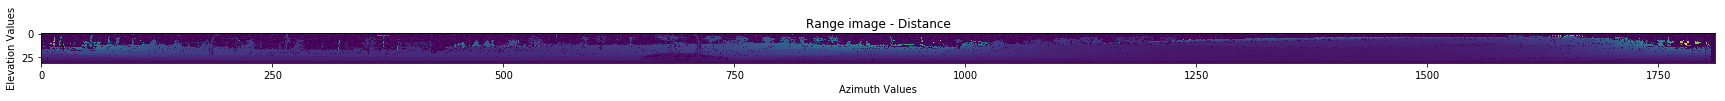

In [90]:
plot_range_image(range_image[: ,:, 0], ylabel="Elevation Values", xlabel="Azimuth Values", title="Range image - Distance")

In [91]:
print("Overlap count:", overlap_count)

Overlap count: 574


## Display the Extracted Data Distributions

In [92]:
def plot(points_to_plot, x_lim=None, y_lim=None):
    # PLOT THE IMAGE
    dpi = 100       # Image resolution

    fig, ax = plt.subplots(figsize=(30,30), dpi=dpi)

    ax = plt.axes(projection ='3d')
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], points_to_plot[:, 2], s=0.2, c=points_to_plot[:, 3])

    ax.view_init(90, 180)

    ax.set_xlabel('$X$', fontsize=20)
    ax.set_ylabel('$Y$', fontsize=20)
    ax.set_zlabel('$Z$', fontsize=20)

    ax.axis('scaled')

    ax.xaxis.set_visible(True)  # Do not draw axis tick marks
    ax.yaxis.set_visible(True)  # Do not draw axis tick marks
    ax.zaxis.set_visible(True)  # Do not draw axis tick marks
    ax.grid(False)

    if x_lim:
        plt.xlim(x_lim)  
    if y_lim:
        plt.ylim(y_lim)

    plt.show()

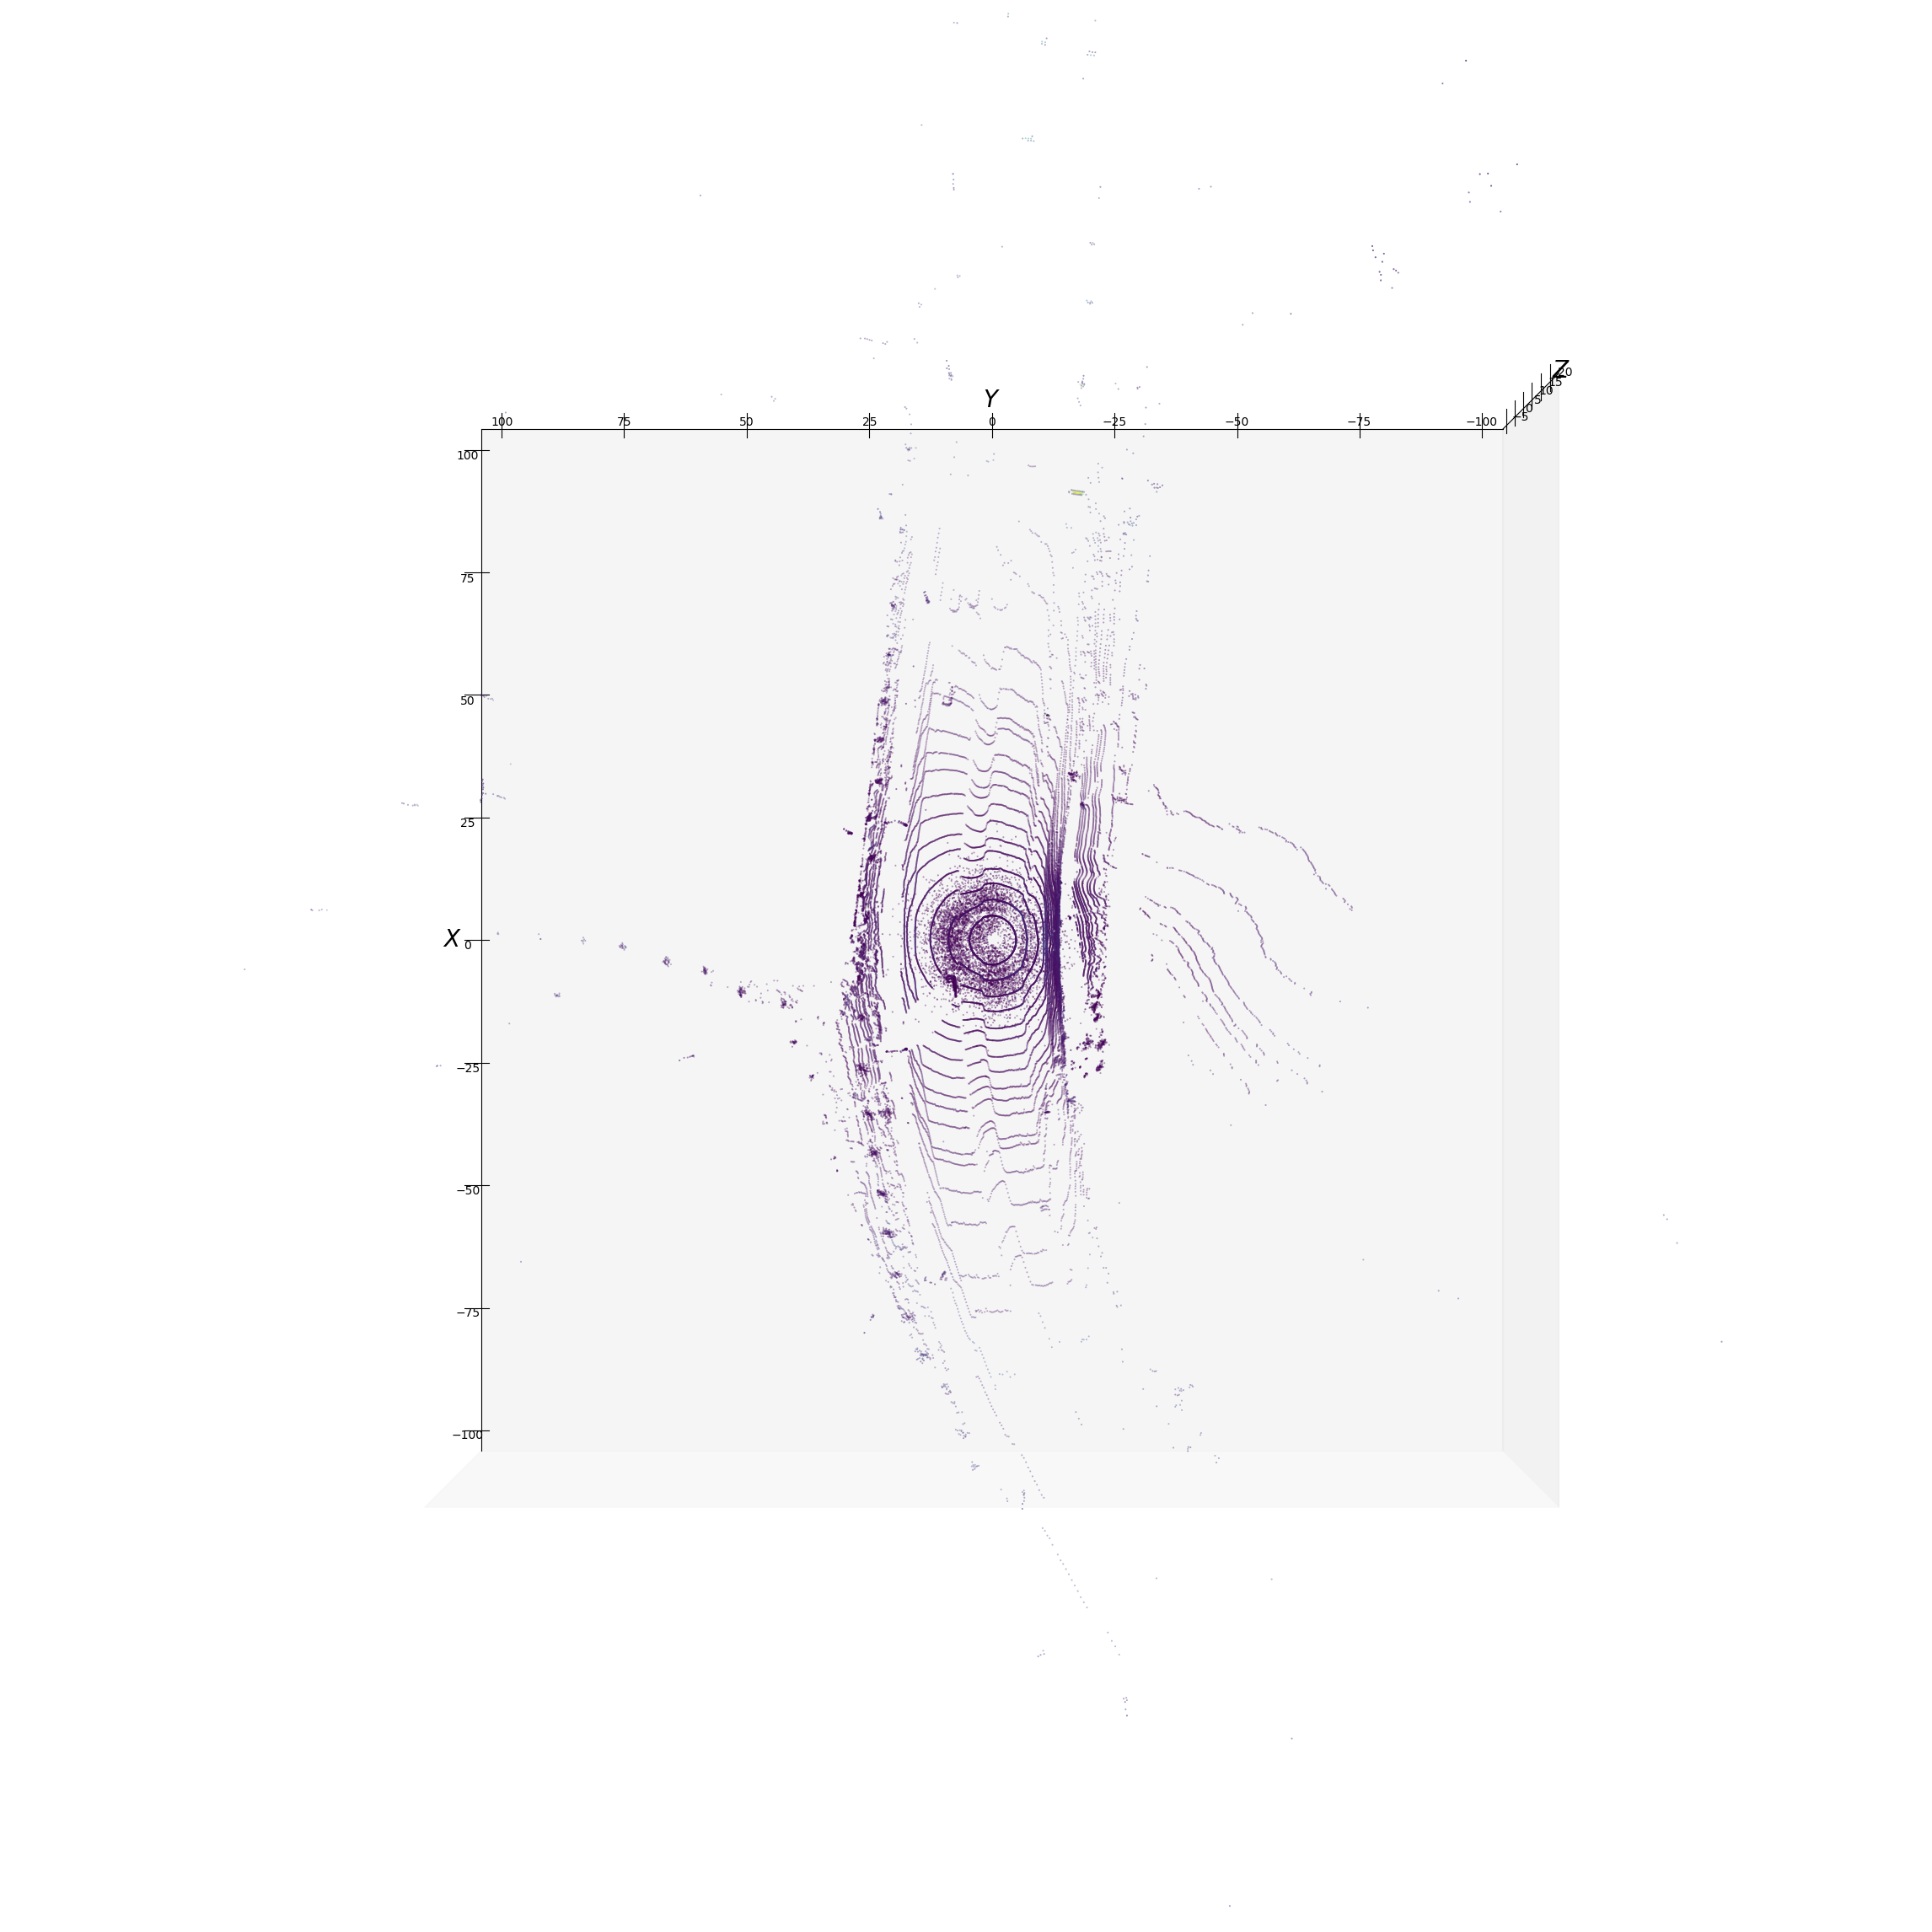

In [94]:
plot(point_cloud, [-100, 100], [-100, 100])

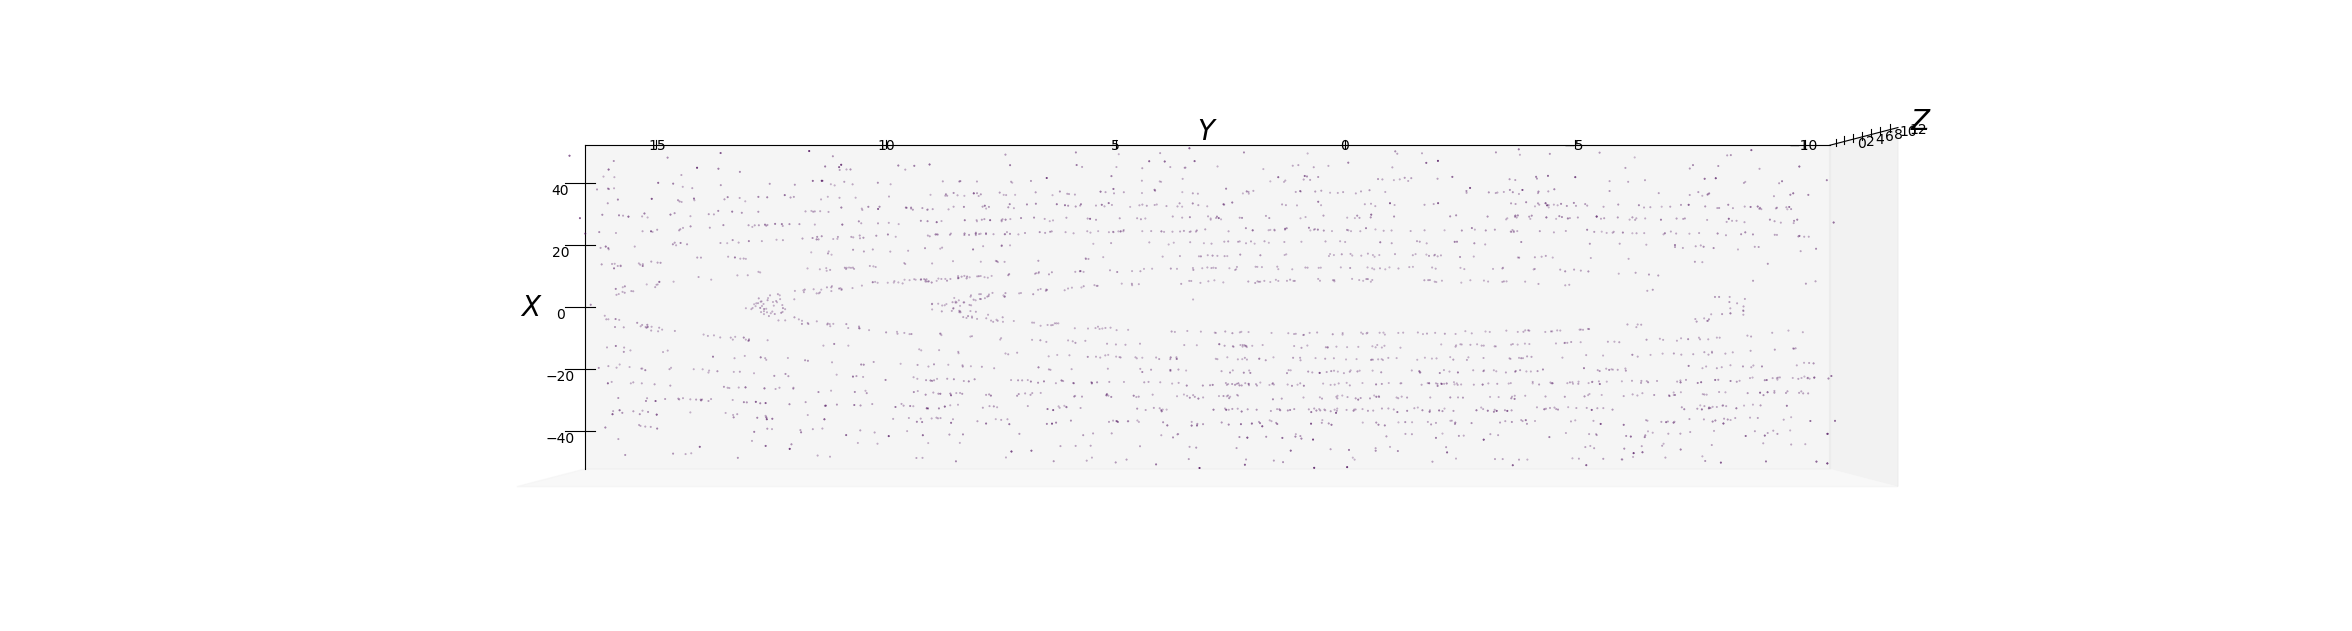

In [65]:
plot(snow_points, x_lim=snow_cropping_x_range, y_lim=snow_cropping_y_range)

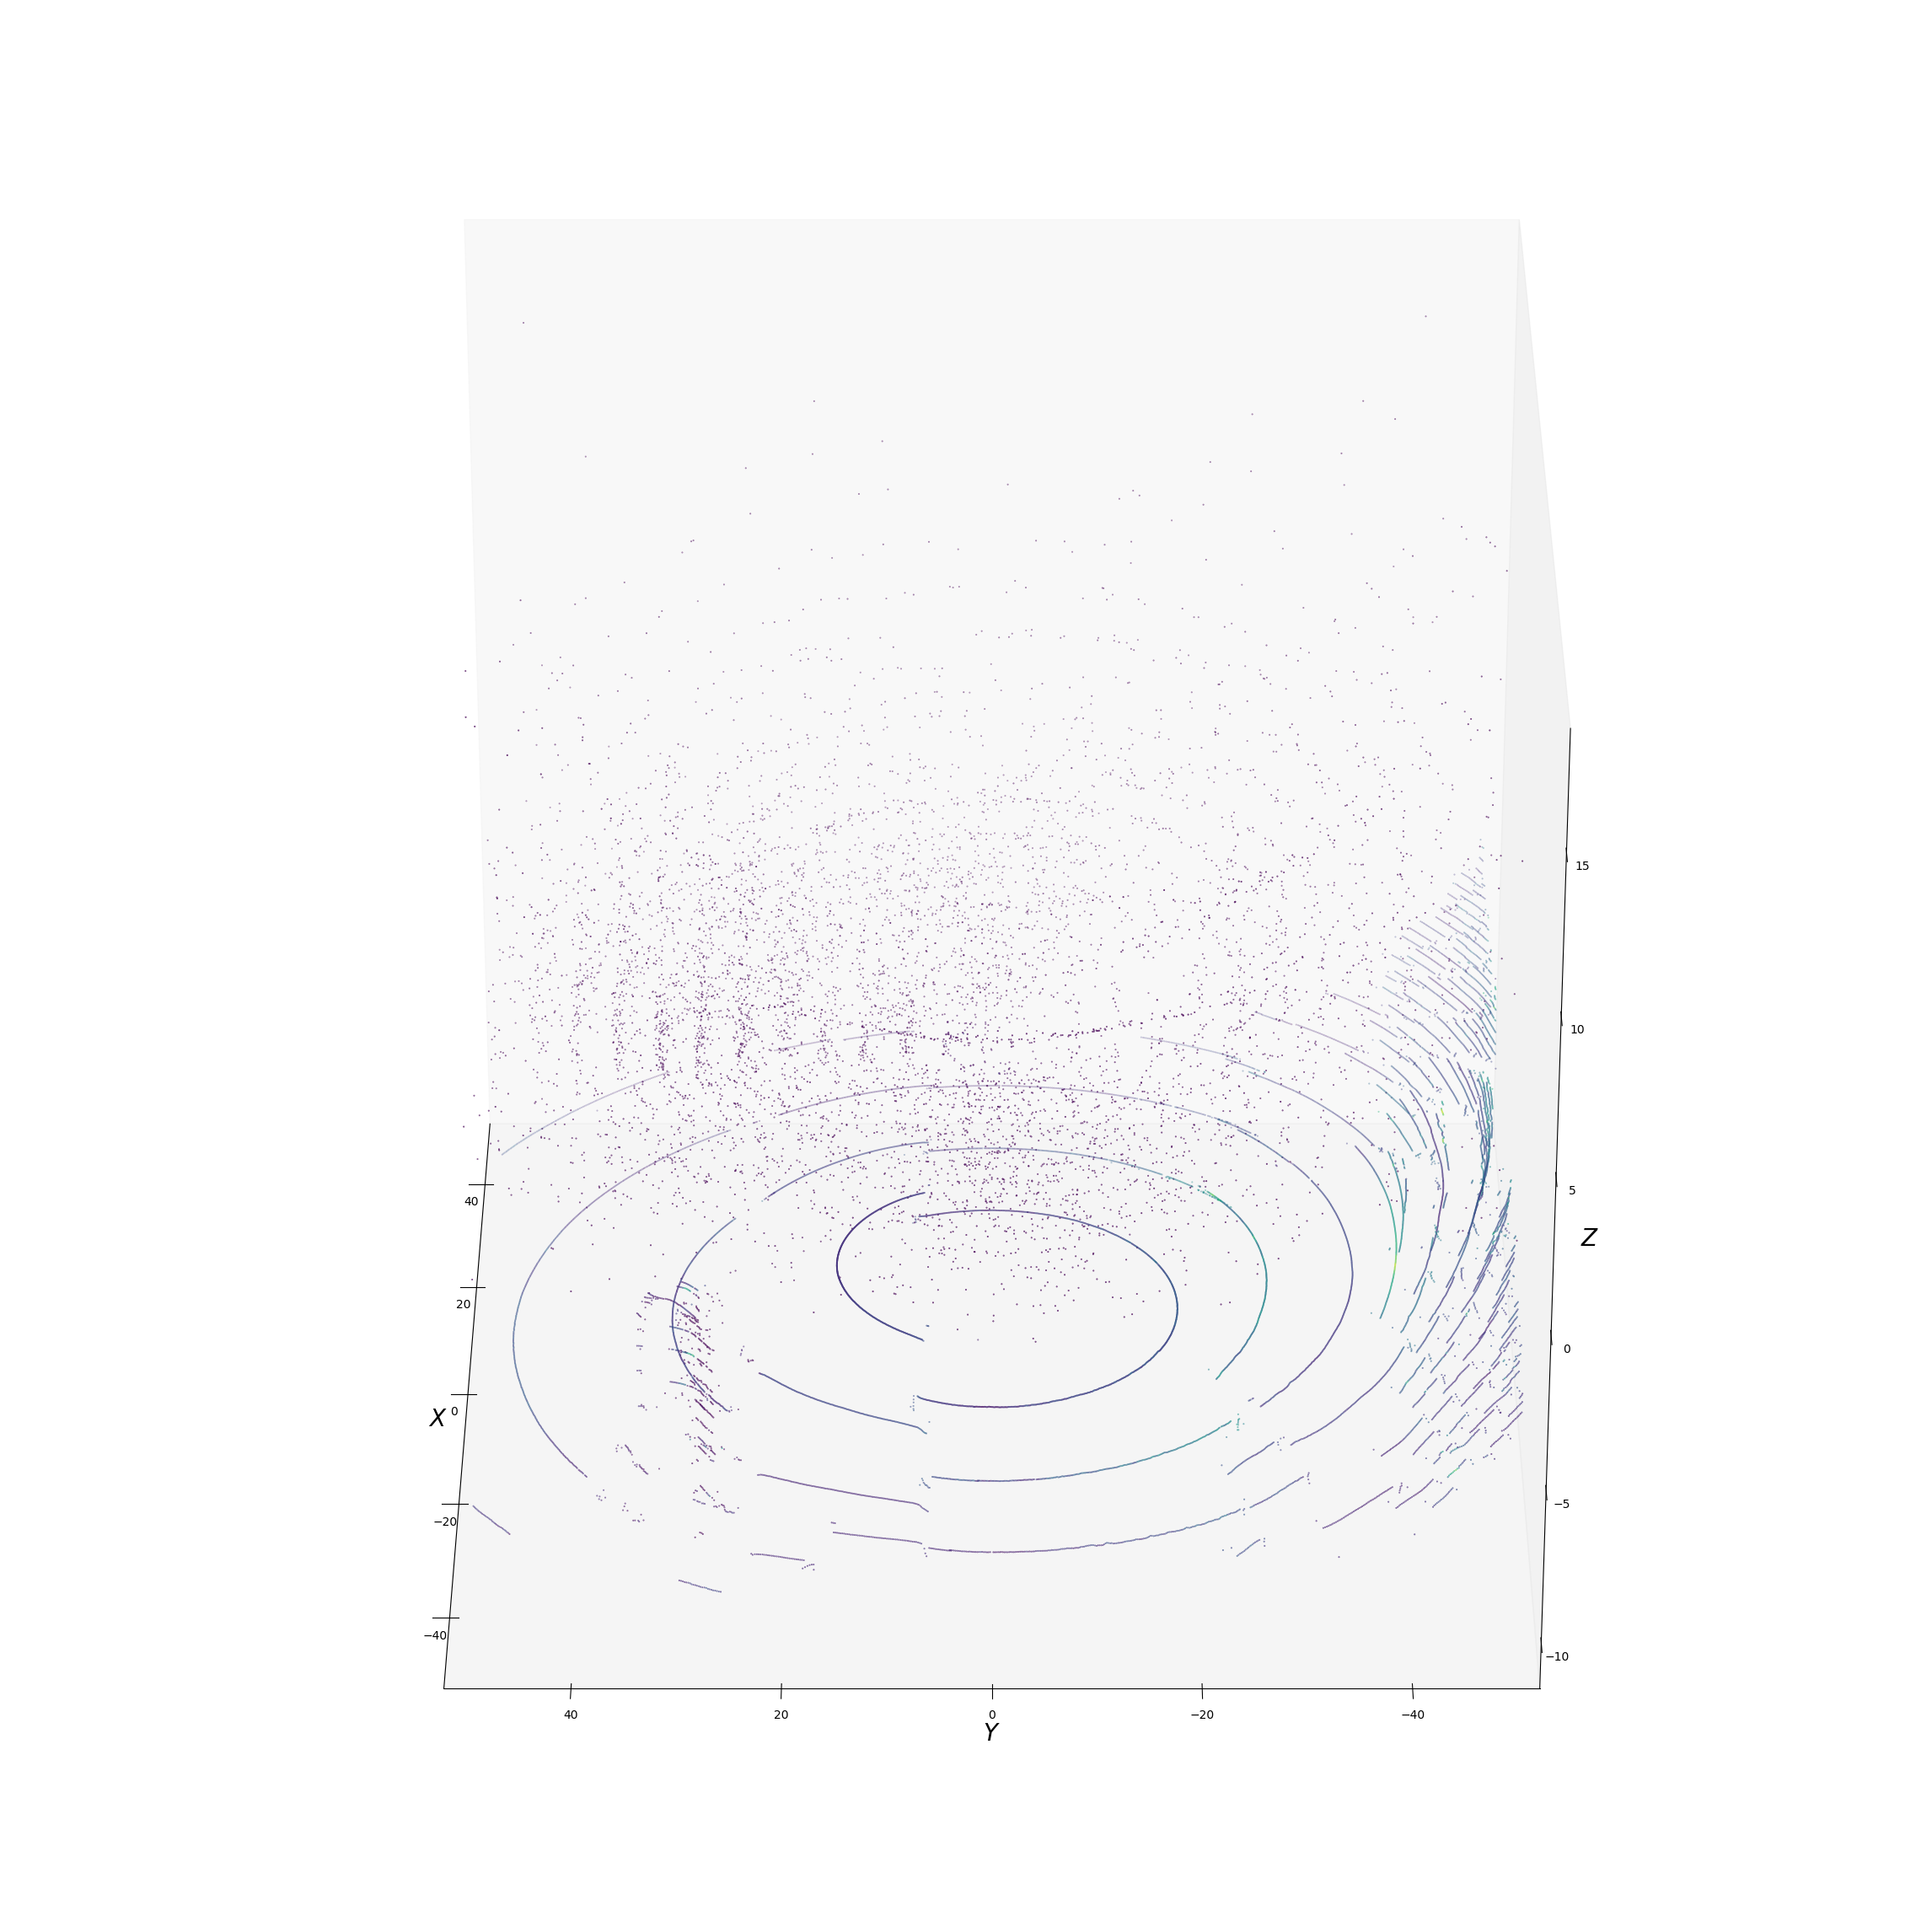

In [27]:
plot(trimmed_lidar_data, x_range, y_range)

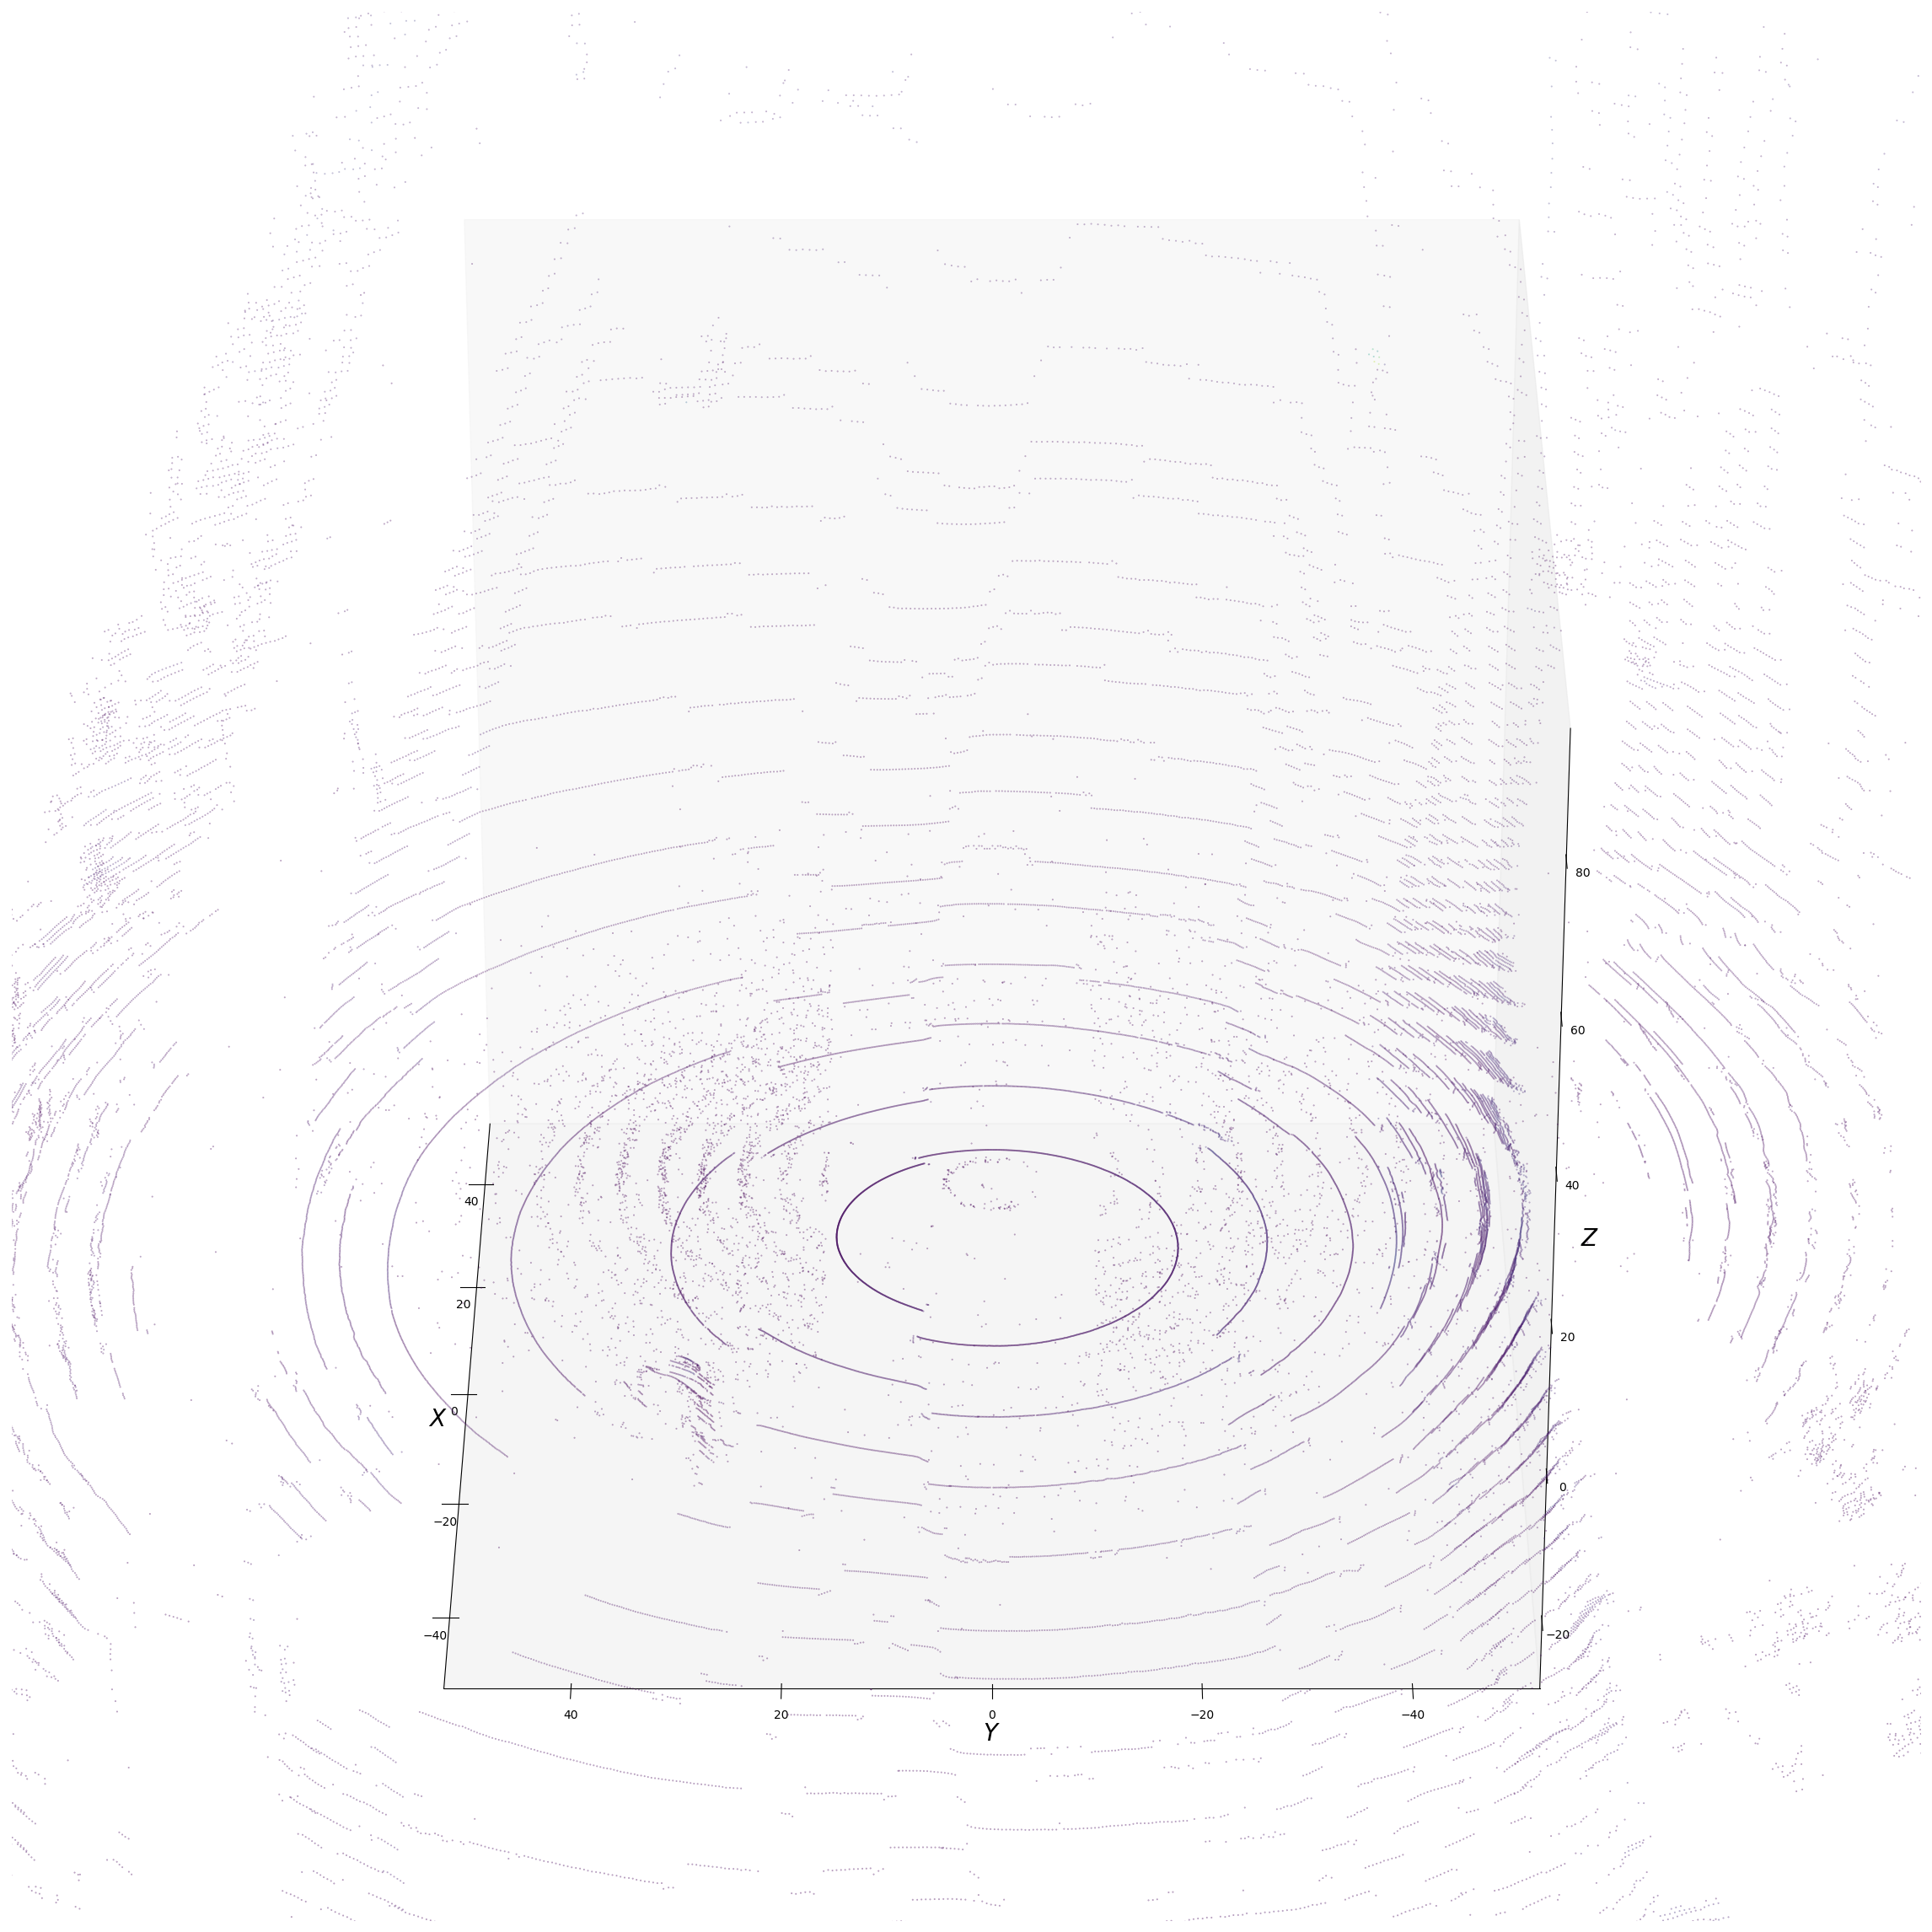

In [28]:
plot(removed_points, x_range, y_range)

## Estimating the Distributions

In [29]:
distance_distribution = []
intensity_distribution = []
distance_per_intensity = {}
n_bins = snow_points.shape[0]

for i in range(n_bins):
    distance = np.sqrt(snow_points[i, 0]**2 + snow_points[i, 1]**2 + snow_points[i, 2]**2)
    intensity = snow_points[i, 3]
    
    distance_distribution.append(distance) 
    intensity_distribution.append(intensity)
     
    distances = distance_per_intensity.get(intensity, [])
    distances.append(distance)
    distance_per_intensity[intensity] = distances
    

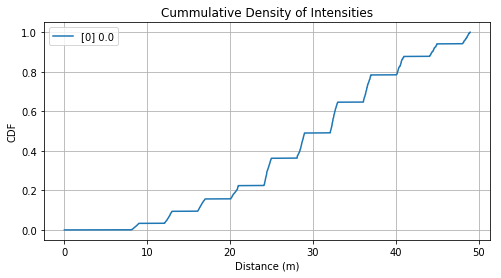

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))

labels = []
for i, intensity in enumerate(sorted(list(distance_per_intensity.keys()))[:]):
    x = [0]
    x += sorted(distance_per_intensity[intensity])
    sum = np.sum(x)
    y = np.cumsum(x) / sum
    ax.plot(x, y)
#     n, bins, patches = ax.hist(distance_per_intensity[i], bins=len(distance_per_intensity[i]), density=True, histtype='step', cumulative=True, label='Empirical')
    labels.append("["+ str(i) +"] " + str(intensity))
    
plt.legend(labels)
ax.grid(True)
ax.set_title('Cummulative Density of Intensities')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
plt.show()

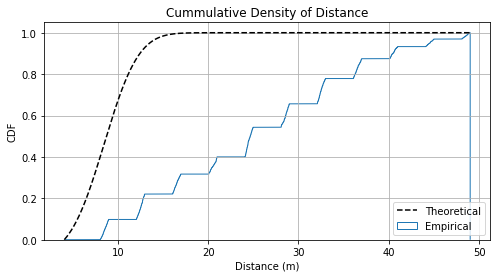

In [34]:
mu = 8.5
sigma = 3
    
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(distance_distribution, bins=n_bins, density=True, histtype='step', cumulative=True, label='Empirical')
ax.grid(True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
    np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
y = y.cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')
ax.grid(True)
ax.set_title('Cummulative Density of Distance')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
plt.legend(['Theoretical', 'Empirical'])
plt.show()
     